# Zalora - Gender Prediction System 

##### Name: Huynh Nguyen Minh Thong
##### Email: tomhuynhsg@gmail.com

### Libraries

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

### Load Data

In [2]:
path='data/'
train_data = pd.read_csv(path + 'trainingData.csv', header=None,
                         parse_dates=[1, 2],
                         names=['Session_ID', 'StartTime', 'EndTime', 'Categories'])
train_label = pd.read_csv(path + 'trainingLabels.csv', header=None)
train_data['Gender'] = (train_label[0].values == 'female').astype(np.float64)

In [3]:
train_data

,Session_ID,StartTime,EndTime,Categories,Gender
0,u10001,2014-11-14 00:02:14,2014-11-14 00:02:20,A00001/B00001/C00001/D00001/,1.0
1,u10002,2014-12-12 14:12:05,2014-12-12 14:12:06,A00002/B00002/C00002/D24897/,1.0
2,u10003,2014-11-14 00:02:41,2014-11-14 00:16:40,A00002/B00002/C00002/D00002/;A00002/B00002/C00...,1.0
3,u10004,2014-11-14 00:21:55,2014-11-14 00:21:57,A00002/B00006/C00015/D00030/,1.0
4,u10005,2014-11-14 00:26:08,2014-11-14 00:29:25,A00002/B00002/C00003/D00033/;A00002/B00002/C00...,1.0
...,...,...,...,...,...
14995,u24996,2014-12-22 22:31:38,2014-12-22 22:35:29,A00002/B00002/C00007/D20565/;A00002/B00002/C00...,1.0
14996,u24997,2014-12-22 22:52:11,2014-12-22 22:53:19,A00002/B00002/C00002/D15648/;A00002/B00002/C00...,1.0
14997,u24998,2014-12-22 22:58:58,2014-12-22 22:59:00,A00002/B00002/C00007/D36054/,1.0
14998,u24999,2014-12-22 23:03:45,2014-12-22 23:03:50,A00002/B00002/C00007/D08424/,1.0


### Data Exploratory

In [4]:
train_data.head()

,Session_ID,StartTime,EndTime,Categories,Gender
0,u10001,2014-11-14 00:02:14,2014-11-14 00:02:20,A00001/B00001/C00001/D00001/,1.0
1,u10002,2014-12-12 14:12:05,2014-12-12 14:12:06,A00002/B00002/C00002/D24897/,1.0
2,u10003,2014-11-14 00:02:41,2014-11-14 00:16:40,A00002/B00002/C00002/D00002/;A00002/B00002/C00...,1.0
3,u10004,2014-11-14 00:21:55,2014-11-14 00:21:57,A00002/B00006/C00015/D00030/,1.0
4,u10005,2014-11-14 00:26:08,2014-11-14 00:29:25,A00002/B00002/C00003/D00033/;A00002/B00002/C00...,1.0


In [5]:
train_data.columns

Index(['Session_ID', 'StartTime', 'EndTime', 'Categories', 'Gender'], dtype='object')

Let's figure out how many categories for each level and their frequency!

In [6]:
from collections import defaultdict
distri_cat = {'A':{},'B':{},'C':{},'D':{}}
for row in train_data['Categories']:
    splited = row.split(',')
    for click in splited[-1].split(';'):
        click_split = click.split('/')[:-1]
        distri_cat['A'][click_split[0]]= distri_cat['A'].get(click_split[0],0) + 1
        distri_cat['B'][click_split[1]]= distri_cat['B'].get(click_split[1],0) + 1
        distri_cat['C'][click_split[2]]= distri_cat['C'].get(click_split[2],0) + 1
        distri_cat['D'][click_split[3]]= distri_cat['D'].get(click_split[3],0) + 1

In [7]:
def show_distribution_cat(distri_cat, level_type, rotation = 30, size = (10,5), visual_type='bar'):
    sorted_freq = sorted(distri_cat[level_type].items(), key=lambda x: x[1])
    cat_list, freq_list=map(list,list(zip(*sorted_freq)))
    plt.figure(figsize = size)
    if visual_type =='bar':
        ax = sns.barplot(x=cat_list, y=freq_list)
        ax.set(title='Bar Frequency for category level '+level_type, xlabel='Category', ylabel='Frequency')
        ax.bar_label(ax.containers[0], label_type='edge')
        ax.set_xticklabels(ax.get_xticklabels(),rotation = rotation)
    else:
        ax = sns.histplot(data=freq_list, bins=50)
        ax.set(title='Histogram Frequency for category level '+level_type, xlabel='Category', ylabel='Frequency')
    plt.show()

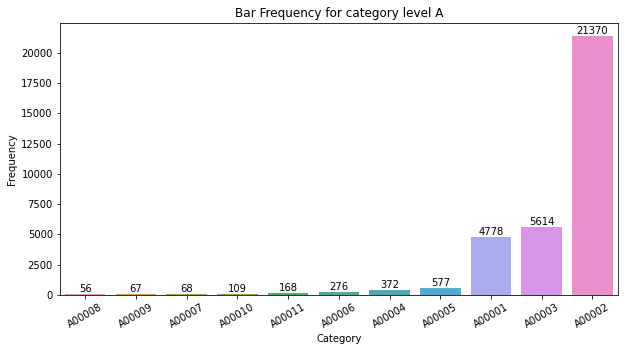

In [8]:
show_distribution_cat(distri_cat, 'A')

Majority of main category A are A00001, A00002, and A00003!Majority of main category products are A00001, A00002, and A00003!

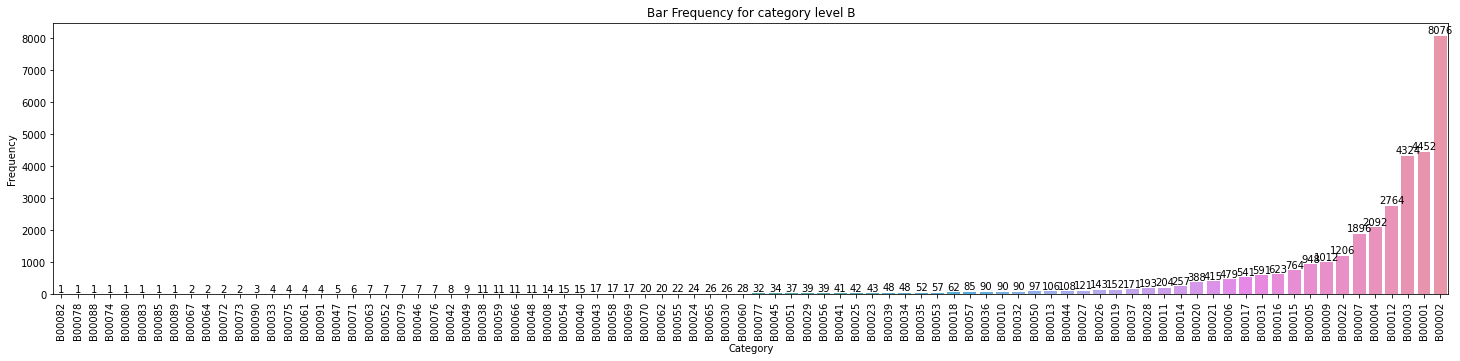

In [9]:
show_distribution_cat(distri_cat, 'B', 90, (25,5))

For level 2 category B, there are around 20 For level 2 category B, there are around 20 popular categories.popular categories.

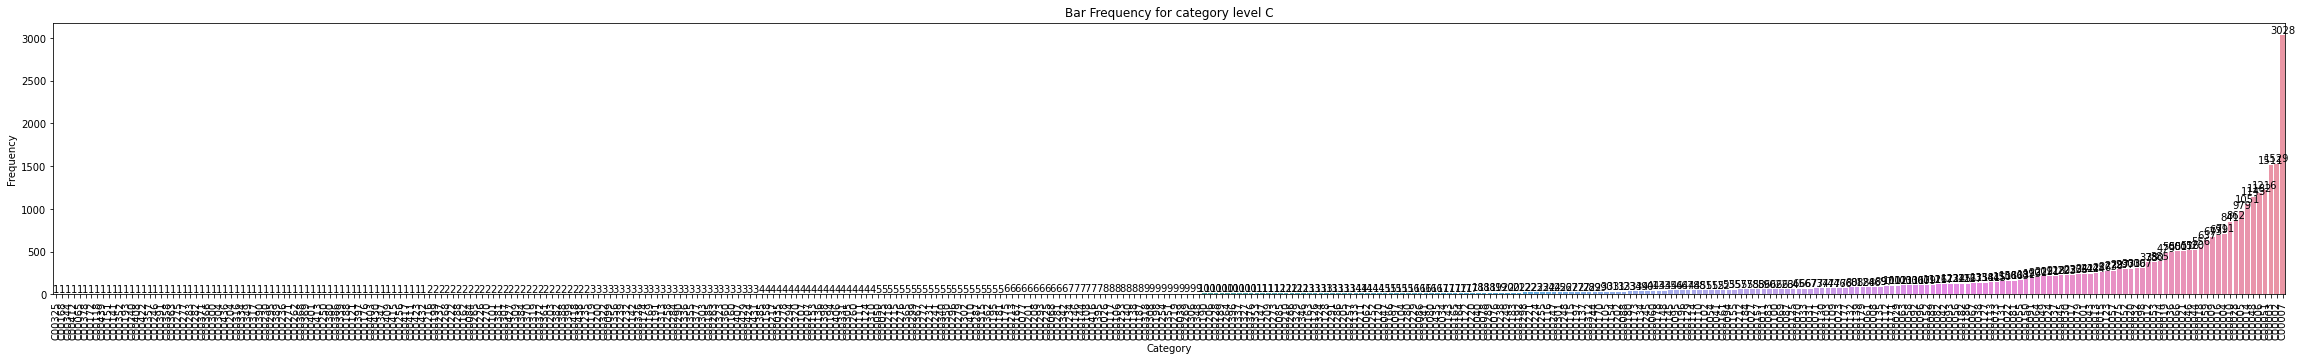

In [10]:
show_distribution_cat(distri_cat, 'C', 90,(40,5))

For level 3 category C, there are even more categories to be considered so let's use histogram distribution to check it out!

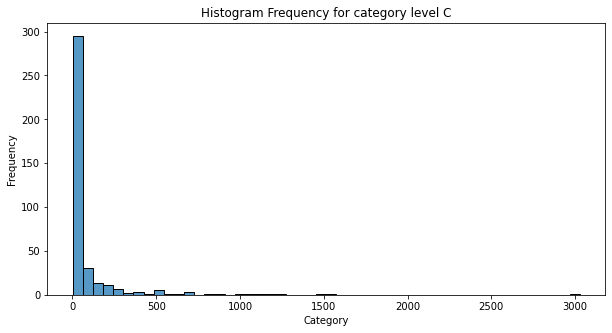

In [11]:
show_distribution_cat(distri_cat, 'C', 90,(10,5), 'hist')

So with this histogram distribution, there are a lot of categories level C got a very few sessions (1->10)!

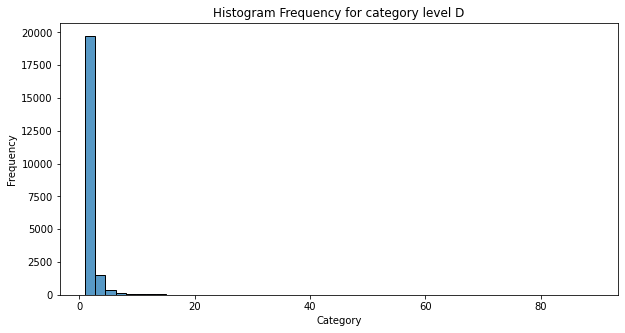

In [12]:
show_distribution_cat(distri_cat, 'D', 90, (10,5), 'hist')

Similarly, for level D product category, most of them got one sessions only!

In [13]:
print(len(distri_cat['A']))
print(len(distri_cat['B']))
print(len(distri_cat['C']))
print(len(distri_cat['D']))

11
86
383
21880


At different hierarcy levels, there are:
- 11 Level A (Categories)
- 86 Level B (Subcategories)
- 383 Level C (Sub-subcategories)
- 21880 Level D (Product ID)

In [14]:
train_data['Gender'].value_counts()

1.0    11703
0.0     3297
Name: Gender, dtype: int64

Also, we noticed there are 11703 females(1) and 3297 males(0) so this dataset is unbalanced! We will take care of this issue later!

### Preprocessing

#### ID Column

Session ID is needed to convert  into number to keep track of which rows are resampled from the same ID.

In [15]:
train_data['Session_ID'] = train_data['Session_ID'].str[1:].astype(int)

In [16]:
train_data

,Session_ID,StartTime,EndTime,Categories,Gender
0,10001,2014-11-14 00:02:14,2014-11-14 00:02:20,A00001/B00001/C00001/D00001/,1.0
1,10002,2014-12-12 14:12:05,2014-12-12 14:12:06,A00002/B00002/C00002/D24897/,1.0
2,10003,2014-11-14 00:02:41,2014-11-14 00:16:40,A00002/B00002/C00002/D00002/;A00002/B00002/C00...,1.0
3,10004,2014-11-14 00:21:55,2014-11-14 00:21:57,A00002/B00006/C00015/D00030/,1.0
4,10005,2014-11-14 00:26:08,2014-11-14 00:29:25,A00002/B00002/C00003/D00033/;A00002/B00002/C00...,1.0
...,...,...,...,...,...
14995,24996,2014-12-22 22:31:38,2014-12-22 22:35:29,A00002/B00002/C00007/D20565/;A00002/B00002/C00...,1.0
14996,24997,2014-12-22 22:52:11,2014-12-22 22:53:19,A00002/B00002/C00002/D15648/;A00002/B00002/C00...,1.0
14997,24998,2014-12-22 22:58:58,2014-12-22 22:59:00,A00002/B00002/C00007/D36054/,1.0
14998,24999,2014-12-22 23:03:45,2014-12-22 23:03:50,A00002/B00002/C00007/D08424/,1.0


#### Time Columns 

Let's do some feature engineering. With the start and end datetime will be converted to:
- Day in month (31)
- Month (12)
- DayofWeek (7)
- StartHour (24)
- EndHour (24)
- Duration (1)
- NoOfProducts (1)
- AverageTimePerProduct (1)

In [17]:
train_data['DayOfWeek']=train_data["StartTime"].dt.dayofweek
train_data['Month']=train_data["StartTime"].dt.month
train_data['Day']=train_data["StartTime"].dt.day
train_data['StartHour'] = train_data["StartTime"].dt.hour
train_data['EndHour'] = train_data["EndTime"].dt.hour
train_data['Duration'] = (train_data["EndTime"] - train_data["StartTime"]).dt.total_seconds()
train_data['NoOfProducts'] = train_data['Categories'].str.count(";")+1
train_data['AverageTimePerProduct'] = train_data['Duration']/train_data['NoOfProducts']

Now, these date and time features are broken down into these new meaningful features like below!

In [18]:
train_data

,Session_ID,StartTime,EndTime,Categories,Gender,DayOfWeek,Month,Day,StartHour,EndHour,Duration,NoOfProducts,AverageTimePerProduct
0,10001,2014-11-14 00:02:14,2014-11-14 00:02:20,A00001/B00001/C00001/D00001/,1.0,4,11,14,0,0,6.0,1,6.000000
1,10002,2014-12-12 14:12:05,2014-12-12 14:12:06,A00002/B00002/C00002/D24897/,1.0,4,12,12,14,14,1.0,1,1.000000
2,10003,2014-11-14 00:02:41,2014-11-14 00:16:40,A00002/B00002/C00002/D00002/;A00002/B00002/C00...,1.0,4,11,14,0,0,839.0,12,69.916667
3,10004,2014-11-14 00:21:55,2014-11-14 00:21:57,A00002/B00006/C00015/D00030/,1.0,4,11,14,0,0,2.0,1,2.000000
4,10005,2014-11-14 00:26:08,2014-11-14 00:29:25,A00002/B00002/C00003/D00033/;A00002/B00002/C00...,1.0,4,11,14,0,0,197.0,3,65.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,24996,2014-12-22 22:31:38,2014-12-22 22:35:29,A00002/B00002/C00007/D20565/;A00002/B00002/C00...,1.0,0,12,22,22,22,231.0,3,77.000000
14996,24997,2014-12-22 22:52:11,2014-12-22 22:53:19,A00002/B00002/C00002/D15648/;A00002/B00002/C00...,1.0,0,12,22,22,22,68.0,4,17.000000
14997,24998,2014-12-22 22:58:58,2014-12-22 22:59:00,A00002/B00002/C00007/D36054/,1.0,0,12,22,22,22,2.0,1,2.000000
14998,24999,2014-12-22 23:03:45,2014-12-22 23:03:50,A00002/B00002/C00007/D08424/,1.0,0,12,22,23,23,5.0,1,5.000000


Here are unique values for each columns!

In [19]:
for i in train_data.columns:
    print(i, '\t', train_data[i].unique())

Session_ID 	 [10001 10002 10003 ... 24998 24999 25000]
StartTime 	 ['2014-11-14T00:02:14.000000000' '2014-12-12T14:12:05.000000000'
 '2014-11-14T00:02:41.000000000' ... '2014-12-22T22:58:58.000000000'
 '2014-12-22T23:03:45.000000000' '2014-12-22T22:34:33.000000000']
EndTime 	 ['2014-11-14T00:02:20.000000000' '2014-12-12T14:12:06.000000000'
 '2014-11-14T00:16:40.000000000' ... '2014-12-22T22:59:00.000000000'
 '2014-12-22T23:03:50.000000000' '2014-12-22T22:34:41.000000000']
Categories 	 ['A00001/B00001/C00001/D00001/' 'A00002/B00002/C00002/D24897/'
 'A00002/B00002/C00002/D00002/;A00002/B00002/C00003/D00003/;A00002/B00002/C00007/D00007/;A00002/B00002/C00002/D00009/;A00002/B00002/C00003/D00010/;A00002/B00002/C00007/D00011/;A00002/B00002/C00002/D00012/;A00002/B00002/C00007/D00014/;A00002/B00002/C00003/D00017/;A00002/B00002/C00011/D00021/;A00002/B00002/C00004/D00023/;A00002/B00002/C00012/D00025/'
 ... 'A00002/B00002/C00007/D36054/' 'A00002/B00002/C00007/D08424/'
 'A00001/B00001/C00012/D22495

Notice that the data includes sessions from November and December so we need to be careful how we should deal with these data so if the production data is other months, we can still deal with it!

For these time-based features "DayOfWeek", "Month", "Day", "StartHour" and "EndHour", it is not ideal to keep them as numerical categories.

Also, it’s not a great choice to one-hot encode these time and date features, as it may lead to a curse of dimensionality.

We will encode the cyclic features (cyclical occurring features) using the basic formulation of trigonometry, by computing the sin and cosine of the features.

For example: the feature "DayOfWeek" has 7 unique feature values. Taking the sin and cosine of the feature values will create 2 dimensionality columns instead of 7 new columns.

In [20]:
def sin_cos_transformation(df, col_name, max_range):
    sin_values = ((df[col_name].astype('float')*2*math.pi)/max_range).apply(math.sin)
    cos_values = ((df[col_name].astype('float')*2*math.pi)/max_range).apply(math.cos)
    df[col_name+'_sin']=sin_values
    df[col_name+'_cos']=cos_values
    df.drop(columns=[col_name], inplace = True)
    return df

In [21]:
train_data = sin_cos_transformation(train_data, 'DayOfWeek', 6)
train_data = sin_cos_transformation(train_data, 'Day', 31)
train_data = sin_cos_transformation(train_data, 'Month', 12)
train_data = sin_cos_transformation(train_data, 'StartHour', 23)
train_data = sin_cos_transformation(train_data, 'EndHour', 23)

In [22]:
train_data

,Session_ID,StartTime,EndTime,Categories,Gender,Duration,NoOfProducts,AverageTimePerProduct,DayOfWeek_sin,DayOfWeek_cos,Day_sin,Day_cos,Month_sin,Month_cos,StartHour_sin,StartHour_cos,EndHour_sin,EndHour_cos
0,10001,2014-11-14 00:02:14,2014-11-14 00:02:20,A00001/B00001/C00001/D00001/,1.0,6.0,1,6.000000,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,0.866025,0.000000e+00,1.000000,0.000000e+00,1.000000
1,10002,2014-12-12 14:12:05,2014-12-12 14:12:06,A00002/B00002/C00002/D24897/,1.0,1.0,1,1.000000,-0.866025,-0.5,0.651372,-0.758758,-2.449294e-16,1.000000,-6.310879e-01,-0.775711,-6.310879e-01,-0.775711
2,10003,2014-11-14 00:02:41,2014-11-14 00:16:40,A00002/B00002/C00002/D00002/;A00002/B00002/C00...,1.0,839.0,12,69.916667,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,0.866025,0.000000e+00,1.000000,0.000000e+00,1.000000
3,10004,2014-11-14 00:21:55,2014-11-14 00:21:57,A00002/B00006/C00015/D00030/,1.0,2.0,1,2.000000,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,0.866025,0.000000e+00,1.000000,0.000000e+00,1.000000
4,10005,2014-11-14 00:26:08,2014-11-14 00:29:25,A00002/B00002/C00003/D00033/;A00002/B00002/C00...,1.0,197.0,3,65.666667,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,0.866025,0.000000e+00,1.000000,0.000000e+00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,24996,2014-12-22 22:31:38,2014-12-22 22:35:29,A00002/B00002/C00007/D20565/;A00002/B00002/C00...,1.0,231.0,3,77.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,1.000000,-2.697968e-01,0.962917,-2.697968e-01,0.962917
14996,24997,2014-12-22 22:52:11,2014-12-22 22:53:19,A00002/B00002/C00002/D15648/;A00002/B00002/C00...,1.0,68.0,4,17.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,1.000000,-2.697968e-01,0.962917,-2.697968e-01,0.962917
14997,24998,2014-12-22 22:58:58,2014-12-22 22:59:00,A00002/B00002/C00007/D36054/,1.0,2.0,1,2.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,1.000000,-2.697968e-01,0.962917,-2.697968e-01,0.962917
14998,24999,2014-12-22 23:03:45,2014-12-22 23:03:50,A00002/B00002/C00007/D08424/,1.0,5.0,1,5.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-2.449294e-16,1.000000


We got no more use for 'StartTime' and 'EndTime'. Let's remove them!

In [23]:
train_data.drop(columns=['StartTime','EndTime'], inplace = True)

#### Categories Columns

(-1.1089940360773027,
 1.1021760882070495,
 -1.1090782998582058,
 1.1004322999988718)

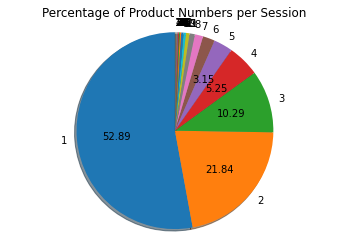

In [24]:
proportion_sessions= train_data['NoOfProducts'].value_counts()/train_data['NoOfProducts'].value_counts().sum()
def my_autopct(pct):
    return ('%.2f' % pct) if pct > 3 else ''
fig1, ax1 = plt.subplots()
ax1.set_title("Percentage of Product Numbers per Session")
ax1.pie(proportion_sessions, labels=proportion_sessions.index, autopct=my_autopct,
        shadow=True, startangle=90,normalize=False)
ax1.axis('equal')

We can see that majority of rows contain only one browsing category session (52.89%). In each session, user may view multiple products, but many of them view one product only. For the session which contains more than one product viewed, I suggest we should break the session into multiple sessions which contain only one product. This can be considered as a resampling approach, in which we create new instances for the dataset by detaching the sessions which contain more than one products to multiple instances which contain only one product.

In [25]:
train_data['Categories']=train_data['Categories'].str.split(";")

In [26]:
train_data= train_data.explode('Categories')
train_data

,Session_ID,Categories,Gender,Duration,NoOfProducts,AverageTimePerProduct,DayOfWeek_sin,DayOfWeek_cos,Day_sin,Day_cos,Month_sin,Month_cos,StartHour_sin,StartHour_cos,EndHour_sin,EndHour_cos
0,10001,A00001/B00001/C00001/D00001/,1.0,6.0,1,6.000000,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,0.866025,0.000000e+00,1.000000,0.000000e+00,1.000000
1,10002,A00002/B00002/C00002/D24897/,1.0,1.0,1,1.000000,-0.866025,-0.5,0.651372,-0.758758,-2.449294e-16,1.000000,-6.310879e-01,-0.775711,-6.310879e-01,-0.775711
2,10003,A00002/B00002/C00002/D00002/,1.0,839.0,12,69.916667,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,0.866025,0.000000e+00,1.000000,0.000000e+00,1.000000
2,10003,A00002/B00002/C00003/D00003/,1.0,839.0,12,69.916667,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,0.866025,0.000000e+00,1.000000,0.000000e+00,1.000000
2,10003,A00002/B00002/C00007/D00007/,1.0,839.0,12,69.916667,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,0.866025,0.000000e+00,1.000000,0.000000e+00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,24997,A00002/B00002/C00007/D36051/,1.0,68.0,4,17.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,1.000000,-2.697968e-01,0.962917,-2.697968e-01,0.962917
14996,24997,A00002/B00002/C00007/D36052/,1.0,68.0,4,17.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,1.000000,-2.697968e-01,0.962917,-2.697968e-01,0.962917
14997,24998,A00002/B00002/C00007/D36054/,1.0,2.0,1,2.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,1.000000,-2.697968e-01,0.962917,-2.697968e-01,0.962917
14998,24999,A00002/B00002/C00007/D08424/,1.0,5.0,1,5.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-2.449294e-16,1.000000


Now, each browsing session is broken down into multiple ones which contain one category. We have from 15,000 rows to 33,455 rows now!

Next, we will continue to break down the category path into "Main Category", "Sub Category", "Sub Sub Category", and "Product Category" columns!

In [27]:
train_data['MainCat'] = train_data['Categories'].str.split("/").str[0]
train_data['SubCat'] = train_data['Categories'].str.split("/").str[1]
train_data['SubSubCat'] = train_data['Categories'].str.split("/").str[2]
train_data['ProductCat'] = train_data['Categories'].str.split("/").str[3]
train_data

,Session_ID,Categories,Gender,Duration,NoOfProducts,AverageTimePerProduct,DayOfWeek_sin,DayOfWeek_cos,Day_sin,Day_cos,Month_sin,Month_cos,StartHour_sin,StartHour_cos,EndHour_sin,EndHour_cos,MainCat,SubCat,SubSubCat,ProductCat
0,10001,A00001/B00001/C00001/D00001/,1.0,6.0,1,6.000000,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,0.866025,0.000000e+00,1.000000,0.000000e+00,1.000000,A00001,B00001,C00001,D00001
1,10002,A00002/B00002/C00002/D24897/,1.0,1.0,1,1.000000,-0.866025,-0.5,0.651372,-0.758758,-2.449294e-16,1.000000,-6.310879e-01,-0.775711,-6.310879e-01,-0.775711,A00002,B00002,C00002,D24897
2,10003,A00002/B00002/C00002/D00002/,1.0,839.0,12,69.916667,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,0.866025,0.000000e+00,1.000000,0.000000e+00,1.000000,A00002,B00002,C00002,D00002
2,10003,A00002/B00002/C00003/D00003/,1.0,839.0,12,69.916667,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,0.866025,0.000000e+00,1.000000,0.000000e+00,1.000000,A00002,B00002,C00003,D00003
2,10003,A00002/B00002/C00007/D00007/,1.0,839.0,12,69.916667,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,0.866025,0.000000e+00,1.000000,0.000000e+00,1.000000,A00002,B00002,C00007,D00007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,24997,A00002/B00002/C00007/D36051/,1.0,68.0,4,17.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,1.000000,-2.697968e-01,0.962917,-2.697968e-01,0.962917,A00002,B00002,C00007,D36051
14996,24997,A00002/B00002/C00007/D36052/,1.0,68.0,4,17.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,1.000000,-2.697968e-01,0.962917,-2.697968e-01,0.962917,A00002,B00002,C00007,D36052
14997,24998,A00002/B00002/C00007/D36054/,1.0,2.0,1,2.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,1.000000,-2.697968e-01,0.962917,-2.697968e-01,0.962917,A00002,B00002,C00007,D36054
14998,24999,A00002/B00002/C00007/D08424/,1.0,5.0,1,5.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-2.449294e-16,1.000000,A00002,B00002,C00007,D08424


We got no more use for the orginial categories column so let's remove it!

In [28]:
train_data.drop(columns=['Categories'], inplace = True)

Next, we need to turn these strings of categories into one-hot-encoding for our ML model to learn!

In [29]:
def encode_and_bind(original_df, feature_to_encode):
    dummies = pd.get_dummies(original_df[[feature_to_encode]].astype(str))
    res = pd.concat([original_df, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

In [30]:
features_to_encode = ['MainCat', 'SubCat', 'SubSubCat', 'ProductCat']
for feature in features_to_encode:
    train_data = encode_and_bind(train_data, feature)

In [31]:
train_data

,Session_ID,Gender,Duration,NoOfProducts,AverageTimePerProduct,DayOfWeek_sin,DayOfWeek_cos,Day_sin,Day_cos,Month_sin,...,ProductCat_D36109,ProductCat_D36110,ProductCat_D36111,ProductCat_D36112,ProductCat_D36113,ProductCat_D36114,ProductCat_D36115,ProductCat_D36116,ProductCat_D36117,ProductCat_D36122
0,10001,1.0,6.0,1,6.000000,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
1,10002,1.0,1.0,1,1.000000,-0.866025,-0.5,0.651372,-0.758758,-2.449294e-16,...,0,0,0,0,0,0,0,0,0,0
2,10003,1.0,839.0,12,69.916667,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
2,10003,1.0,839.0,12,69.916667,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
2,10003,1.0,839.0,12,69.916667,-0.866025,-0.5,0.299363,-0.954139,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14996,24997,1.0,68.0,4,17.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,...,0,0,0,0,0,0,0,0,0,0
14996,24997,1.0,68.0,4,17.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,...,0,0,0,0,0,0,0,0,0,0
14997,24998,1.0,2.0,1,2.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,...,0,0,0,0,0,0,0,0,0,0
14998,24999,1.0,5.0,1,5.000000,0.000000,1.0,-0.968077,-0.250653,-2.449294e-16,...,0,0,0,0,0,0,0,0,0,0


Our features is increased from 20 to 22,375 features!

In [32]:
print ("We have", len(train_data.columns.values), "features in total in our dataset!")

We have 22375 features in total in our dataset!


### Using SMOTE for the imbalanced dataset

In [33]:
print("The number of samples in the current data:", len(train_data))
print("Number of Male labels in the current data:", len(train_data[train_data['Gender']==0]))
print("Number of Female labels in the current data:", len(train_data[train_data['Gender']==1]))
print("Proportion of Male labels in the current data:", len(train_data[train_data['Gender']==0])/len(train_data))
print("Proportion of Female labels in the current data:", len(train_data[train_data['Gender']==1])/len(train_data))

The number of samples in the current data: 33455
Number of Male labels in the current data: 7071
Number of Female labels in the current data: 26384
Proportion of Male labels in the current data: 0.2113585413241668
Proportion of Female labels in the current data: 0.7886414586758332


As you can see, our data is quite unbalanced with 21% male labels and 78% female labels which can cause issues for the model to train and for choosing the right evaluation metrics. That is why we need to resolve this!

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X, os_data_y=os.fit_resample(X_train, y_train)

In [34]:
y = train_data['Gender']
X = train_data.drop(columns=['Gender'])

Remember we should over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [36]:
os = SMOTE(random_state=0)
X_train_os, y_train_os=os.fit_resample(X_train, y_train)

It's time to double check if SMOTE is working alright!

In [37]:
print("The number of samples in the oversampled data:", len(X_train_os))
print("Number of Male labels in the oversampled data:", len(y_train_os[y_train_os==0]))
print("Number of Female labels in the oversampled data:", len(y_train_os[y_train_os==1]))
print("Proportion of Male labels in the oversampled data:", len(y_train_os[y_train_os==0])/len(X_train_os))
print("Proportion of Female labels in the oversampled data:", len(y_train_os[y_train_os==1])/len(X_train_os))

The number of samples in the oversampled data: 36906
Number of Male labels in the oversampled data: 18453
Number of Female labels in the oversampled data: 18453
Proportion of Male labels in the oversampled data: 0.5
Proportion of Female labels in the oversampled data: 0.5


Now we have a perfect balanced data! 

### Model

In [38]:
X_test=X_test.set_index('Session_ID')
X_train_os=X_train_os.set_index('Session_ID')

In [39]:
X_train_os

,Duration,NoOfProducts,AverageTimePerProduct,DayOfWeek_sin,DayOfWeek_cos,Day_sin,Day_cos,Month_sin,Month_cos,StartHour_sin,...,ProductCat_D36109,ProductCat_D36110,ProductCat_D36111,ProductCat_D36112,ProductCat_D36113,ProductCat_D36114,ProductCat_D36115,ProductCat_D36116,ProductCat_D36117,ProductCat_D36122
Session_ID,,,,,,,,,,,,,,,,,,,,,
16547,1.000000,1,1.000000,0.866025,-0.5,-0.651372,-0.758758,-5.000000e-01,0.866025,-0.269797,...,0,0,0,0,0,0,0,0,0,0
21495,75.000000,3,25.000000,-0.866025,0.5,0.937752,0.347305,-2.449294e-16,1.000000,0.942261,...,0,0,0,0,0,0,0,0,0,0
21001,330.000000,6,55.000000,0.000000,1.0,0.998717,-0.050649,-2.449294e-16,1.000000,-0.398401,...,0,0,0,0,0,0,0,0,0,0
16675,225.000000,3,75.000000,-0.866025,0.5,0.485302,-0.874347,-2.449294e-16,1.000000,0.398401,...,0,0,0,0,0,0,0,0,0,0
12848,82.000000,2,41.000000,0.866025,-0.5,-0.299363,-0.954139,-2.449294e-16,1.000000,-0.816970,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18935,467.000000,6,68.547999,0.866025,-0.5,-0.848644,0.528964,-5.000000e-01,0.866025,-0.972817,...,0,0,0,0,0,0,0,0,0,0
20762,3.155584,1,3.155584,0.000000,1.0,0.488116,-0.587800,-2.449294e-16,1.000000,-0.094294,...,0,0,0,0,0,0,0,0,0,0
20918,1125.000000,14,80.357143,-0.866025,0.5,-0.790776,-0.612106,-2.449294e-16,1.000000,0.816970,...,0,0,0,0,0,0,0,0,0,0


In [40]:
y_train_os

0        0.0
1        0.0
2        0.0
3        1.0
4        0.0
        ... 
36901    0.0
36902    0.0
36903    0.0
36904    0.0
36905    0.0
Name: Gender, Length: 36906, dtype: float64

#### Metrics

For the metrics, we will use a variety of them to provide as much as information to evaluate our models:
- Balanced Accuracy Measure (BAC) = 0.5*(tp/(tp+fn) + tn/(tn+fp))
- Normal Accuracy (True/Total) = (tp+tn)/(tp+fp+tn+fn)
- Precision, Recall, F1-score
- ROC Curve

In [41]:
def model_report(model, model_name):
    y_train_pred = model.predict(X_train_os)
    y_test_pred = model.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_train_os, y_train_pred).ravel()
    score = 0.5*(tp/(tp+fn) + tn/(tn+fp))
    print("Balanced Accuracy Score (BAC) for train data: ", score)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    score = 0.5*(tp/(tp+fn) + tn/(tn+fp))
    print("Balanced Accuracy Score (BAC) for test data: ", score)
    
    print(f'Accuracy of {model_name} classifier on train set: {model.score(X_train_os, y_train_os)}')
    print(f'Accuracy of {model_name} classifier on test set: {model.score(X_test, y_test)}')
    
    print("Confusion Matrix for test data:")
    print(confusion_matrix(y_test, y_test_pred))
    
    print("Precision, Recall, F1-score for test data:")
    print(classification_report(y_test, y_test_pred))
    
    print("ROC Curve for test data:")
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (area = {logit_roc_auc})')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

#### Logistic Regression (Baseline Model)

Balanced Accuracy Score (BAC) for train data:  0.5000270958651709
Balanced Accuracy Score (BAC) for test data:  0.4876786583906325
Accuracy of Logistic Regression classifier on train set: 0.500027095865171
Accuracy of Logistic Regression classifier on test set: 0.45352196871575173
Confusion Matrix for test data:
[[1151  955]
 [4530 3401]]
Precision, Recall, F1-score for test data:
              precision    recall  f1-score   support

         0.0       0.20      0.55      0.30      2106
         1.0       0.78      0.43      0.55      7931

    accuracy                           0.45     10037
   macro avg       0.49      0.49      0.42     10037
weighted avg       0.66      0.45      0.50     10037

ROC Curve for test data:


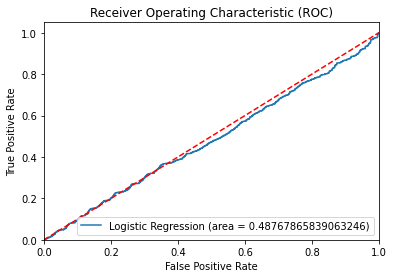

In [44]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_os, y_train_os)
model_report(logistic_model, "Logistic Regression")

#### Naive Baynes

Balanced Accuracy Score (BAC) for train data:  0.506475911775863
Balanced Accuracy Score (BAC) for test data:  0.5124547333285198
Accuracy of Naive Bayes classifier on train set: 0.506475911775863
Accuracy of Naive Bayes classifier on test set: 0.2501743548869184
Confusion Matrix for test data:
[[2031   75]
 [7451  480]]
Precision, Recall, F1-score for test data:
              precision    recall  f1-score   support

         0.0       0.21      0.96      0.35      2106
         1.0       0.86      0.06      0.11      7931

    accuracy                           0.25     10037
   macro avg       0.54      0.51      0.23     10037
weighted avg       0.73      0.25      0.16     10037

ROC Curve for test data:


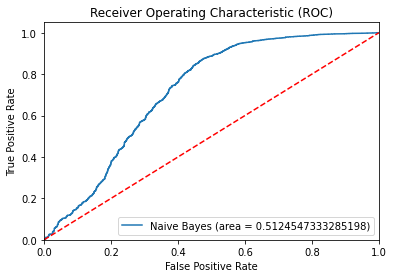

In [47]:
gnb = GaussianNB()
gnb.fit(X_train_os, y_train_os)
model_report(gnb, "Naive Bayes")

#### Decision Tree 

Balanced Accuracy Score (BAC) for train data:  0.9999729041348291
Balanced Accuracy Score (BAC) for test data:  0.8635050374532576
Accuracy of Decision Tree classifier on train set: 0.999972904134829
Accuracy of Decision Tree classifier on test set: 0.9113280860814984
Confusion Matrix for test data:
[[1645  461]
 [ 429 7502]]
Precision, Recall, F1-score for test data:
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79      2106
         1.0       0.94      0.95      0.94      7931

    accuracy                           0.91     10037
   macro avg       0.87      0.86      0.87     10037
weighted avg       0.91      0.91      0.91     10037

ROC Curve for test data:


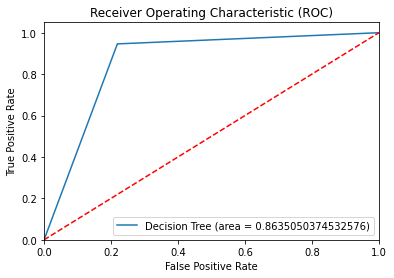

In [45]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train_os, y_train_os)
model_report(decision_tree, "Decision Tree")

#### Random Forest

Balanced Accuracy Score (BAC) for train data:  0.9999729041348291
Balanced Accuracy Score (BAC) for test data:  0.8900771109508974
Accuracy of Random Forest classifier on train set: 0.999972904134829
Accuracy of Random Forest classifier on test set: 0.9362359270698416
Confusion Matrix for test data:
[[1707  399]
 [ 241 7690]]
Precision, Recall, F1-score for test data:
              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84      2106
         1.0       0.95      0.97      0.96      7931

    accuracy                           0.94     10037
   macro avg       0.91      0.89      0.90     10037
weighted avg       0.94      0.94      0.94     10037

ROC Curve for test data:


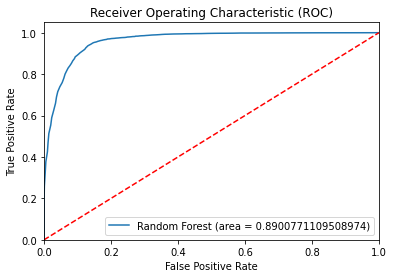

In [46]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train_os, y_train_os)
model_report(random_forest, "Random Forest")

#### XGBoost

[22:15:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Balanced Accuracy Score (BAC) for train data:  0.9449412019725789
Balanced Accuracy Score (BAC) for test data:  0.8431369062437024
Accuracy of XGBoost classifier on train set: 0.944941201972579
Accuracy of XGBoost classifier on test set: 0.9108299292617316
Confusion Matrix for test data:
[[1530  576]
 [ 319 7612]]
Precision, Recall, F1-score for test data:
              precision    recall  f1-score   support

         0.0       0.83      0.73      0.77      2106
         1.0       0.93      0.96      0.94      7931

    accuracy                           0.91     10037
   macro avg       0.88      0.84      0.86     10037
weighted avg       0.91      0.91      0.91     10037

ROC Curve for test data:


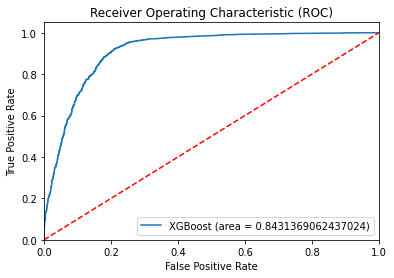

In [48]:
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train_os, y_train_os)
model_report(xgb, "XGBoost")

#### DeepLearning with Tensorflow

Since we got a large number for features and enough amount of samples, we can try deep learning for the win!

First, we need to convert dataframe into tensors (a special type of numpy for tensorflow)

In [42]:
X_train_tensor_os = tf.convert_to_tensor(X_train_os)
y_train_tensor_os = tf.convert_to_tensor(y_train_os)

In [43]:
X_test_tensor = tf.convert_to_tensor(X_test)
y_test_tensor = tf.convert_to_tensor(y_test)

Define our basic fully connected neural network:

In [44]:
model = keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(X_train_tensor_os.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

We need to define extra info for our model:
- Optimizers: Adam (best default optimizer)
- Loss function: Binary Crossentrophy (because of binary classification)
- metrics: Accuracy 

In [45]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                357984    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 358,273
Trainable params: 358,273
Non-trainable params: 0
_________________________________________________________________


Our model is looking alright!

We need to add some useful callbacks to improve the training process:
- Training faster by stopping early before the point it becomes overfitting (EarlyStopping)
- Keep a model weight backup with the lowest loss for the test set to restore back later (ModelCheckpoint)
- Reduce the learning rate if there is no progress for a few epoches (ReduceLROnPlateau)

In [47]:
# our callbacks hell to optimize our learning
callbacks = [
    ModelCheckpoint(
        filepath='checkpoint_weights.hdf5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=20,
        restore_best_weights=True,
        verbose=1),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1)
]
callbacks_list = callbacks

It's time to fit the model!

In [48]:
history = model.fit(X_train_tensor_os, y_train_tensor_os,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_test_tensor, y_test_tensor), 
                    callbacks = callbacks_list)

Epoch 1/50
287/289 [============================>.] - ETA: 0s - loss: 3.1060 - accuracy: 0.6921
Epoch 00001: val_loss improved from inf to 6.26943, saving model to checkpoint_weights.hdf5
289/289 [==============================] - 2s 7ms/step - loss: 3.0964 - accuracy: 0.6924 - val_loss: 6.2694 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 2/50
280/289 [============================>.] - ETA: 0s - loss: 1.1511 - accuracy: 0.8333
Epoch 00002: val_loss improved from 6.26943 to 1.56820, saving model to checkpoint_weights.hdf5
289/289 [==============================] - 2s 7ms/step - loss: 1.1393 - accuracy: 0.8340 - val_loss: 1.5682 - val_accuracy: 0.8512 - lr: 0.0010
Epoch 3/50
283/289 [============================>.] - ETA: 0s - loss: 0.5980 - accuracy: 0.8721
Epoch 00003: val_loss improved from 1.56820 to 0.38643, saving model to checkpoint_weights.hdf5
289/289 [==============================] - 2s 6ms/step - loss: 0.5944 - accuracy: 0.8724 - val_loss: 0.3864 - val_accuracy: 0.8722 - lr: 0.0

As you can see, the model stopped early due to overfitting and it keeps the weights which got the lowest loss!

After training, we need to look at the graph of loss and accuracy to figure out if our model is overfitting at which epoch.

In [49]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [52]:
def show_training_graph(history, metric):
    if metric=='loss':
        train_data = history.history['loss']
        test_data = history.history['val_loss']
    else:
        train_data = history.history['accuracy']
        test_data  = history.history['val_accuracy']
    
    epochs = range(len(history.history['accuracy']))

    plt.figure(figsize=(10,5))
    plt.plot(epochs, train_data, 'b', label='Training')
    plt.plot(epochs, test_data, 'r', label='Validation')
    plt.title('Training vs. Validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

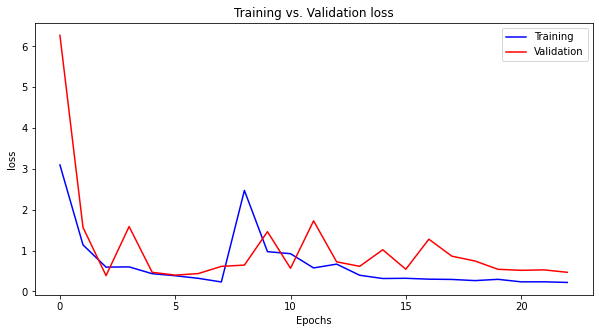

In [53]:
show_training_graph(history,'loss')

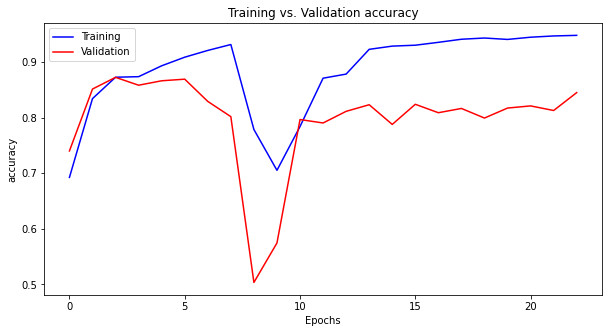

In [54]:
show_training_graph(history,'accuracy')

As you can see from the graph, the model starts to overfit after the epoch 3 with no improvement afterward for loss value of the test set!

In [67]:
def deeplearing_model_report(model, model_name):
    y_train_pred = tf.greater(model.predict(X_train_tensor_os), .5)
    y_test_pred = tf.greater(model.predict(X_test_tensor), .5)
    
    tn, fp, fn, tp = confusion_matrix(y_train_tensor_os, y_train_pred).ravel()
    score = 0.5*(tp/(tp+fn) + tn/(tn+fp))
    print("Balanced Accuracy Score (BAC) for train data: ", score)
    
    tn, fp, fn, tp = confusion_matrix(y_test_tensor, y_test_pred).ravel()
    score = 0.5*(tp/(tp+fn) + tn/(tn+fp))
    print("Balanced Accuracy Score (BAC) for test data: ", score)
    
    print(f'Accuracy of {model_name} classifier on train set: {model.evaluate(X_train_tensor_os, y_train_tensor_os)[1]}')
    print(f'Accuracy of {model_name} classifier on test set: {model.evaluate(X_test_tensor, y_test_tensor)[1]}')
    
    print("Confusion Matrix for test data:")
    print(confusion_matrix(y_test_tensor, y_test_pred))
    
    print("Precision, Recall, F1-score for test data:")
    print(classification_report(y_test_tensor, y_test_pred))
    
    print("ROC Curve for test data:")
    logit_roc_auc = roc_auc_score(y_test_tensor, y_test_pred)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test_tensor))
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (area = {logit_roc_auc})')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

Balanced Accuracy Score (BAC) for train data:  0.8721617081233404
Balanced Accuracy Score (BAC) for test data:  0.7820575684653355
1154/1154 [==============================] - 2s 1ms/step - loss: 0.3380 - accuracy: 0.8722
Accuracy of DenseNet classifier on train set: 0.8721616864204407
314/314 [==============================] - 0s 1ms/step - loss: 0.3864 - accuracy: 0.8722
Accuracy of DenseNet classifier on test set: 0.8721729516983032
Confusion Matrix for test data:
[[1320  786]
 [ 497 7434]]
Precision, Recall, F1-score for test data:
              precision    recall  f1-score   support

         0.0       0.73      0.63      0.67      2106
         1.0       0.90      0.94      0.92      7931

    accuracy                           0.87     10037
   macro avg       0.82      0.78      0.80     10037
weighted avg       0.87      0.87      0.87     10037

ROC Curve for test data:


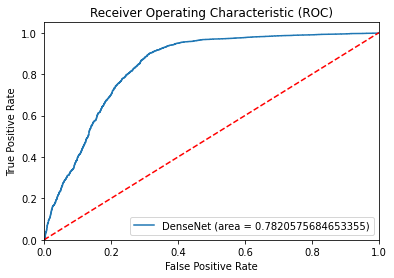

In [68]:
deeplearing_model_report(model, 'DenseNet')

### Conclusion (Answers for Question 4 and 5)

Here is the grand summary of results of each model for Balanced Accuracy Measure (BAC) of the test set:
- Logistic Regression (Baseline Model): 0.487 
- Naive Baynes: 0.512
- Deep Learning (basic dense layers): 0.782
- Decision Tree: 0.863
- XGBoost: 0.843
- Random Forest: 0.890

As the results, Random Forest is the best model so far among the models I have tried so far!

Due to time limit for this assignment, this is the basic investigation for this interesting ecommerce dataset.

However, if I have more time, I would look into a few things to improve the pipeline and models:
- For unbalanced data, instead of oversampling or undersampling, I could look into Cost-sensitive learning which add different weights to samples to make up for the missing quantitiy.
- For category column, instead of breaking each sessions with many products into multiple rows with single product, I could figure out how to setup hierarchy tree with mutiple-levels and also combine bi-gram to make use of the sequences of previous product to current product and to next product.
- Since I selected Random Forest model as the best model, I can further fine tune the model with grid-search and random-search to select the optimal parameters. Also, Using cross-validation will provide less-bias way to select the test set and evaluate optimal parameters.

Thank you!